In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


### ABRIMOS LOS ARCHIVOS

In [323]:
# abrimos el archivo con datos individuales
eph_ind_ = pd.read_excel("usu_individual_T423.xlsx")
# abrimos el archivo por hogar
eph_hog_ = pd.read_excel("usu_hogar_T423.xlsx")

In [324]:
eph_ind = eph_ind_.copy()
print(eph_ind.shape)
eph_hog = eph_hog_.copy()
print(eph_hog.shape)

(47337, 177)
(16462, 88)


# Parte I:

In [325]:
# Solo preservamos las observaciones de GBA y Caba (Aglomerados 32 y 33)
eph_ind = eph_ind[eph_ind['AGLOMERADO'].isin([32, 33])].reset_index(drop=True)
eph_hog = eph_hog[eph_hog['AGLOMERADO'].isin([32, 33])].reset_index(drop=True)
print(eph_ind.shape, eph_hog.shape)

(7380, 177) (2672, 88)


## Ejercicio 2 - Merge de bases

In [326]:
# Unimos las bases de datos utilizando las variables CODUSU y NRO_HOGAR
eph_merged = pd.merge(eph_ind, eph_hog, on=['CODUSU', 'NRO_HOGAR'], how='inner')
print(eph_merged.shape)
# eliminamos las columnas que tienen el mismo nombre en ambas y la copia se marca con _y
duplicol = [col for col in eph_merged.columns if col.endswith(('_y'))]
eph_merged = eph_merged.drop(columns=duplicol)
# sacamos el marcador de que corresponde a la primer base de datos
for i in eph_merged.columns:
  if i.endswith('_x'):
    eph_merged=eph_merged.rename(columns={i:i.replace('_x', '')})

(7380, 263)


## Ejercicio 3 - Limpieza

### Variables no relevantes

In [327]:
# Variables a eliminar (hogares)
eliminar = ["ANO4",  "REALIZADA", "TRIMESTRE", "REGION", "MAS_500", "IV1_ESP", "IV3_ESP", "IV7_ESP", "II3", "II5", "II6", "II7_ESP",
"II8_ESP", "IDECIFR", "RDECIFR", "GDECIFR", "PDECIFR", "ADECIFR", "IPCF", "DECCFR", "IDECCFR", "RDECCFR", "GDECCFR", 
"PDECCFR", "ADECCFR", "IV2"]
eph_merged = eph_merged.drop(columns=[i for i in eliminar if i in eph_merged])

REEMPLAZAMOS NO RESPUESTA Y OUTLIERS NAN

In [328]:
# ELIMINAMOS PENSIONADOS Y SERVICIOS EN VIVIENDA COMO EXPLICAMOS EN EL REPORTE
eph_merged = eph_merged[eph_merged['NRO_HOGAR'] != 71]
eph_merged = eph_merged[eph_merged['NRO_HOGAR'] != 51]


# EN LAS ESTRATEGIAS V1 - V19_B TENEMOS QUE LA NO RESPUESTA ES 9=NAN
for i in [ 'V1', 'V2', 'V21', 'V22', 'V3', 'V4', 'V5', 'V6', 'V8', 'V9', 
    'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19_A', 'V19_B']:
    eph_merged[i].replace(9, np.nan, inplace=True)


# USAMOS DECIFR PARA LIMPIAR ITF 
## SI DECIFR=12 ENTONCES ES NO RESPUESTAITF=NAN
eph_merged.loc[eph_merged['DECIFR'] == 12, 'ITF'] = np.nan


## en las variables de ingreso -9 es no respuesta (nan)
ingreso = [
"PP08D1",
"PP08D4",
"PP08F1",
"PP08F2",
"PP08J1",
"PP08J2",
"PP08J3",
"P21",
"TOT_P12",
"P47T",
"V2_M",
"V3_M",
"V4_M",
"V5_M",
"V8_M",
"V9_M",
"V10_M",
"V11_M",
"V12_M",
"V18_M",
"V19_AM",
"V19_AM",
"V21_M",
"T_VI"
]
for i in ingreso:
    eph_merged[i].replace(-9, np.nan, inplace=True)

## Ejercicio 4 - Construccion de variables

In [329]:
#Indicador de Hacinamiento: con esta variable, obtenemos información acerca de la cantidad de personas durmiendo en cada habitación. A partir de esta información, podemos detectar hogares vulnerables si hay pocos dormitorios en un hogar reltivo a la cantidad de personas
eph_merged['hacinamiento'] = eph_merged ['II2'] / eph_merged ['IX_TOT']

#Cantidad de subsidios sobre el ingreso total: si los programas sociales están bien asignados, los hogares más vulnerables deberían tener mayor proporción de ingresos provenientes por transferencias públicas
eph_merged['ingresos_subsidios'] = eph_merged ['V5_M'] / eph_merged ['ITF']


# Proporcion de menores de edad
eph_merged['MEQ10PROP'] = eph_merged['IX_MEN10'] / eph_merged['IX_TOT']
eph_merged.drop(["IX_MAYEQ10", "IX_MEN10"], axis=1, inplace=True)

# VII1 y VII1_2 para la variable de servicio domestico
eph_merged['VII1_1_servicio_realiza'] = (eph_merged['VII1_1'] == 96).astype(int)
eph_merged['VII2_1_servicio_ayuda'] = (eph_merged['VII2_1'] == 96).astype(int)
eph_merged.drop(['VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4'], axis=1, inplace=True)

# IV8-IV11 resumidas en 4 como describimos en el reporte
eph_merged['IV8_IV11_tiene_dentro_vivienda_cloaca'] = ((eph_merged['IV8'] == 1) & (eph_merged['IV9'] == 1) & (eph_merged['IV11'] == 1)).astype(int)
eph_merged['IV8_IV11_tiene_fuera_vivienda_cloaca'] = ((eph_merged['IV8'] == 1) & ((eph_merged['IV9'] == 2) | (eph_merged['IV9'] == 3)) & (eph_merged['IV11'] == 1)).astype(int)
eph_merged['IV8_IV11_tiene_dentro_vivienda_sin_cloaca'] = ((eph_merged['IV8'] == 1) & (eph_merged['IV9'] == 1) & ((eph_merged['IV11'] == 2) | (eph_merged['IV11'] == 3) | (eph_merged['IV11'] == 4))).astype(int)
eph_merged['IV8_IV11_tiene_fuera_vivienda_sin_cloaca'] = ((eph_merged['IV8'] == 1) & ((eph_merged['IV9'] == 2) | (eph_merged['IV9'] == 3)) & ((eph_merged['IV11'] == 2) | (eph_merged['IV11'] == 3) | (eph_merged['IV11'] == 4))).astype(int)
eph_merged.drop(['IV8', 'IV9', 'IV10', 'IV11'], axis=1, inplace=True)


## Ejercicio 5 - Estadísticas descriptivas

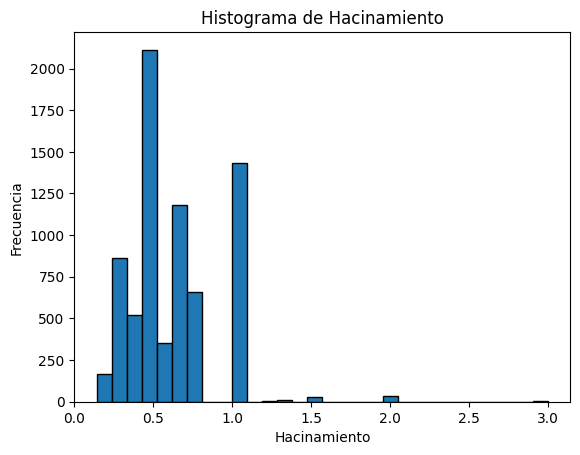

<Figure size 640x480 with 0 Axes>

In [330]:
import seaborn as sns
plt.hist(eph_merged['hacinamiento'], bins=30, edgecolor='black')
plt.title('Histograma de Hacinamiento')
plt.xlabel('Hacinamiento')
plt.ylabel('Frecuencia')
plt.show()
plt.savefig('histograma_hacinamiento.png')

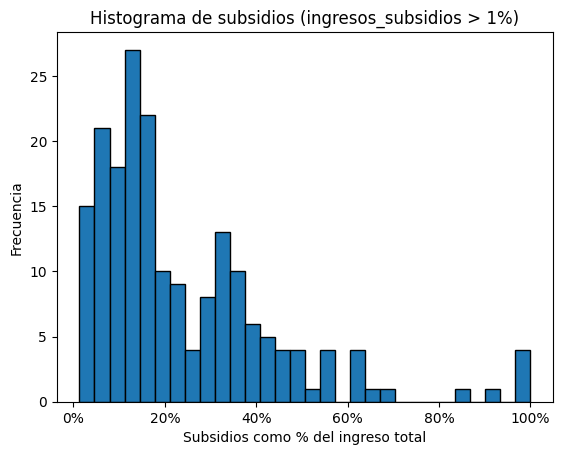

<Figure size 640x480 with 0 Axes>

In [331]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Filtrar datos donde 'ingresos_subsidios' sea mayor al 5%
eph_merged_cleaned = eph_merged[np.isfinite(eph_merged['ingresos_subsidios'])]
eph_filtered = eph_merged_cleaned[eph_merged_cleaned['ingresos_subsidios'] > 0.01]

# Trazar el histograma con los datos filtrados
plt.hist(eph_filtered['ingresos_subsidios'], bins=30, edgecolor='black')
plt.title('Histograma de subsidios (ingresos_subsidios > 1%)')
plt.xlabel('Subsidios como % del ingreso total')
plt.ylabel('Frecuencia')

# Configurar el formato del eje X en porcentaje
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

plt.show()
plt.savefig('histograma_subsidio_filtrado.png')


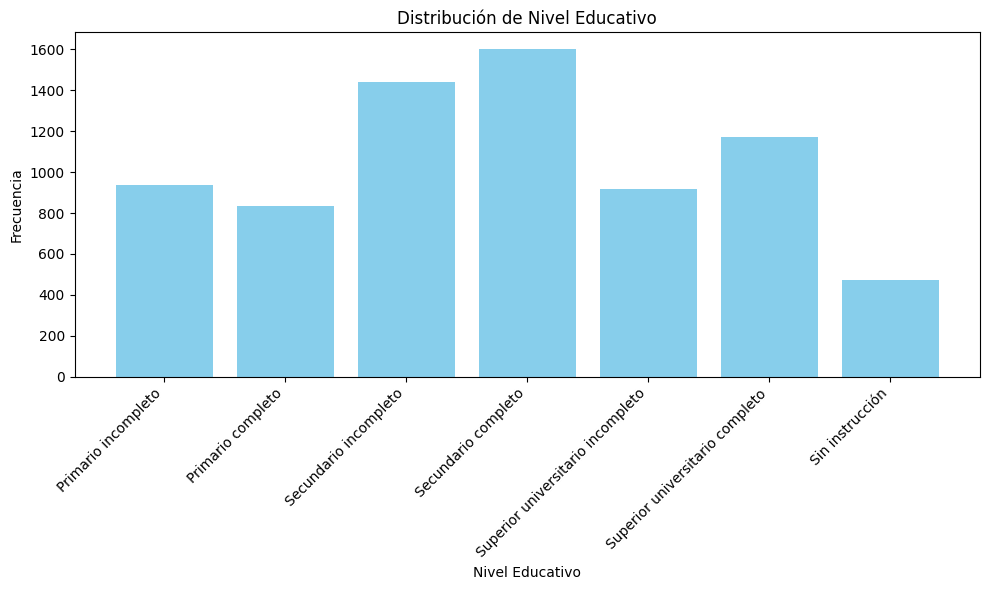

<Figure size 640x480 with 0 Axes>

In [332]:
# Diccionario de mapeo de valores numéricos a descripciones
mapeo_descripciones = {
    1: 'Primario incompleto',
    2: 'Primario completo',
    3: 'Secundario incompleto',
    4: 'Secundario completo',
    5: 'Superior universitario incompleto',
    6: 'Superior universitario completo',
    7: 'Sin instrucción',
    9: 'Ns/Nr'
}

# Contar la frecuencia de cada valor en la variable NIVEL_ED
frecuencias = eph_merged['NIVEL_ED'].value_counts().sort_index()

# Obtener las descripciones correspondientes a los valores numéricos
descripciones = [mapeo_descripciones.get(valor, 'Desconocido') for valor in frecuencias.index]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(descripciones, frecuencias, color='skyblue')
plt.title('Distribución de Nivel Educativo')
plt.xlabel('Nivel Educativo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para mejor visualización
plt.tight_layout()
plt.show()
plt.savefig('nivel_ed.png')

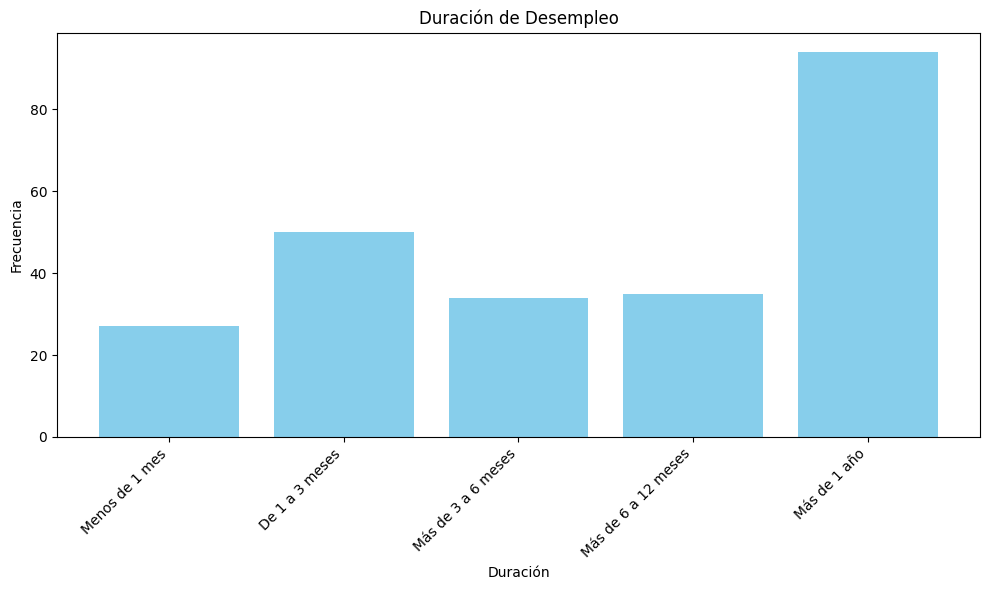

<Figure size 640x480 with 0 Axes>

In [333]:
# Diccionario de mapeo de valores numéricos a descripciones
mapeo_descripciones = {
    1: 'Menos de 1 mes',
    2: 'De 1 a 3 meses',
    3: 'Más de 3 a 6 meses',
    4: 'Más de 6 a 12 meses',
    5: 'Más de 1 año'
}

# Contar la frecuencia de cada valor en la variable PP10A
frecuencias = eph_merged['PP10A'].value_counts().sort_index()

# Obtener las descripciones correspondientes a los valores numéricos
descripciones = [mapeo_descripciones.get(valor, 'Desconocido') for valor in frecuencias.index]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(descripciones, frecuencias, color='skyblue')
plt.title('Duración de Desempleo')
plt.xlabel('Duración')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para mejor visualización
plt.tight_layout()
plt.show()
plt.savefig('desempleo.png')

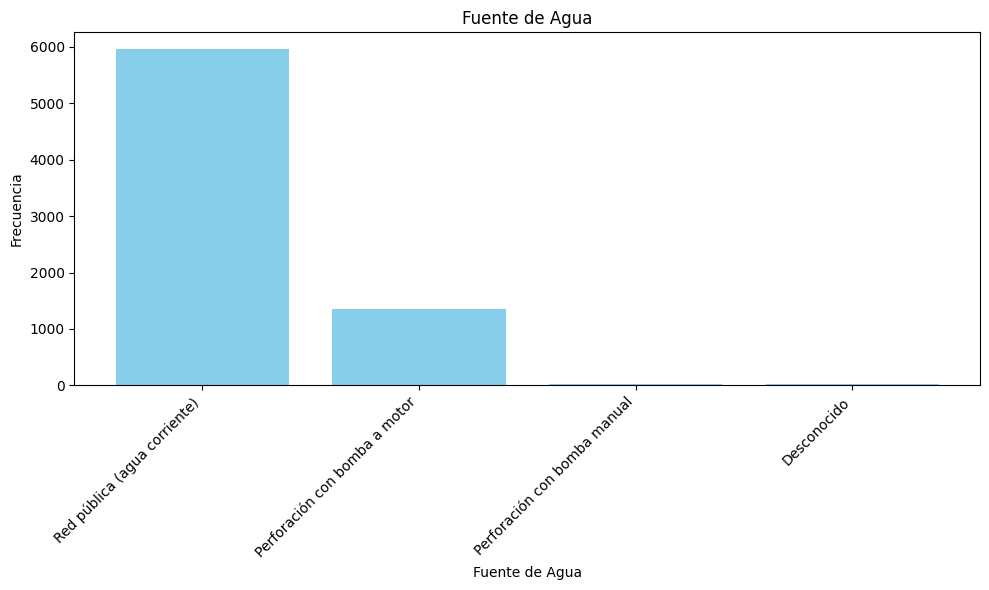

<Figure size 640x480 with 0 Axes>

In [334]:
# Diccionario de mapeo de valores numéricos a descripciones
mapeo_descripciones = {
    1: 'Red pública (agua corriente)',
    2: 'Perforación con bomba a motor',
    3: 'Perforación con bomba manual'
}

# Contar la frecuencia de cada valor en la variable IV7
frecuencias = eph_merged['IV7'].value_counts().sort_index()

# Obtener las descripciones correspondientes a los valores numéricos
descripciones = [mapeo_descripciones.get(valor, 'Desconocido') for valor in frecuencias.index]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(descripciones, frecuencias, color='skyblue')
plt.title('Fuente de Agua')
plt.xlabel('Fuente de Agua')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para mejor visualización
plt.tight_layout()
plt.show()
plt.savefig('agua.png')

## EJERCICIO 6 - RELACIÓN ENTRE INGRESO FAMILIAR PER CÁPITA Y EDUCACIÓN

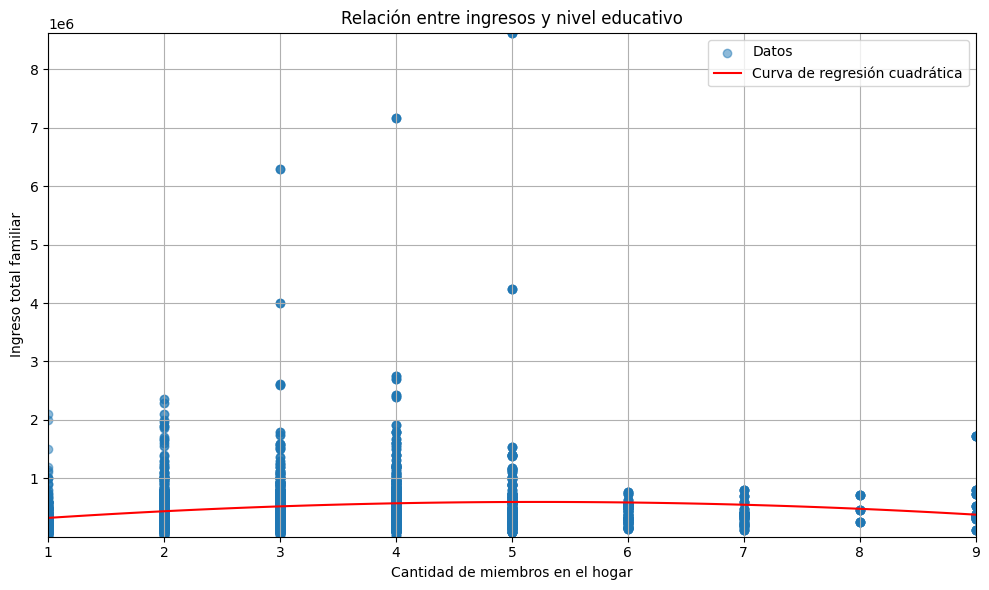

In [335]:
# Filtrar los datos donde ITF > 0
filtered_data = eph_merged[eph_merged['ITF'] > 0]

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['IX_TOT'], filtered_data['ITF'], alpha=0.5, label='Datos')

# Calcular la línea de regresión cuadrática y dibujarla
x = filtered_data['IX_TOT']
y = filtered_data['ITF']
coefficients = np.polyfit(x, y, 2)  # Ajuste polinómico de grado 2 (cuadrático)
poly = np.poly1d(coefficients)
curve_x = np.linspace(x.min(), x.max(), 100)
plt.plot(curve_x, poly(curve_x), color='red', label='Curva de regresión cuadrática')

# Agregar etiquetas y título
plt.title('Relación entre ingresos y nivel educativo')
plt.xlabel('Cantidad de miembros en el hogar')
plt.ylabel('Ingreso total familiar')
plt.grid(True)
plt.legend()

# Ajustar los límites de los ejes
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())

# Ajustar las etiquetas del eje X para mostrar los valores reales
plt.xticks(np.arange(x.min(), x.max() + 1, 1))

# Guardar el gráfico antes de mostrarlo en pantalla
plt.tight_layout()
plt.savefig('regresion_cuadratica.png')
plt.show()


## EJERCICIO 7 - Adulto equivalente


In [336]:
# Obtener todos los valores únicos de la columna CH06 y ordenarlos de mayor a menor
valores_unicos_CH06_ordenados = eph_merged['CH06'].dropna().unique()
valores_unicos_CH06_ordenados.sort()
valores_unicos_CH06_ordenados = valores_unicos_CH06_ordenados[::+1]

# Mostrar los valores únicos ordenados
print(valores_unicos_CH06_ordenados)


[ -1   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  98  99 101]


In [337]:
# leemos el documento y acomodamos el nombre de las columnas
ad_equiv = pd.read_excel("tabla_adulto_equiv.xlsx")
ad_equiv.rename(columns={'Tabla de equivalencias de necesidades energéticas. Unidades de adulto equivalente, según sexo y edad': 'edad', 
                         'Unnamed: 1': 'mujeres', 
                         'Unnamed: 2': 'varones'}, 
                inplace=True)

# borramos las columnas que no necesitamos
ad_equiv.drop([0,1,2,3,27,28,29,30,31,32,33,34,35,36,37,38], inplace=True)
ad_equiv.reset_index(drop=True, inplace=True)

# generamos en la base de eph la columna de necesidades energeticas
eph_merged['adulto_equiv'] = np.nan


# agarramos en cada rango de edades descrito como string el comienzo y el final del rango
# esta funcion rango le das un string y crea una lista con los numeros que haya en ese string
def rangos(s):             
    num_str = ''
    edades = []
    for car in s:
        if car.isdigit():
            num_str += car
        elif num_str:
            edades.append(int(num_str))
            num_str = ''
    if num_str:
        edades.append(int(num_str))
    return edades

# hacemos que la columna de strings que describen los rangos sea una columna de listas
ad_equiv['edad'] = ad_equiv['edad'].apply(rangos)

# hacemos que cada lista tenga dos elementos, comienzo y final, tal que los lea python (1 más que el valor final)
for r in ad_equiv['edad']:
    if len(r) == 1:
        r.append(r[-1] + 1)
    else:
        r[-1] += 1

ad_equiv.loc[0, 'edad'][0],  ad_equiv.loc[0, 'edad'][1]= 0, 1   # corregimos el primer rango
ad_equiv.loc[ad_equiv.index[-1], 'edad'][-1] = 150              # el ultimo rango lo hacemos hasta 150


# asignamos las necesidades electricas a la columna de eph
for index, row in ad_equiv.iterrows():
    age_list = list(range(row['edad'][0], row['edad'][1]))
    for sex, column in [(1, 'varones'), (2, 'mujeres')]:
        # aca asigna en 'adulto_equiv' los que cumpla la condicion de su respectiva edad y sexo
        eph_merged.loc[(eph_merged['CH06'].isin(age_list)) & (eph_merged['CH04'] == sex), 'adulto_equiv'] = row[column]


In [338]:
eph_merged = eph_merged.assign(ad_equiv_hogar=eph_merged.groupby('CODUSU')['adulto_equiv'].transform('sum'))
eph_merged[['ad_equiv_hogar', 'CODUSU', 'CH06']]

,ad_equiv_hogar,CODUSU,CH06
0,2.78,TQRMNOPPQHJNOPCDEIJAH00802435,21
1,2.78,TQRMNOPPQHJNOPCDEIJAH00802435,52
2,2.78,TQRMNOPPQHJNOPCDEIJAH00802435,57
3,2.00,TQRMNOPPQHMMOLCDEIIAD00812035,60
4,2.00,TQRMNOPPQHMMOLCDEIIAD00812035,51
...,...,...,...
7375,1.78,TQVMNOQVXHMLNUCDEIIAD00854940,24
7376,0.63,TQVMNORSXHKOOMCDEIJAH00791846,77
7377,2.24,TQVMNORVXHLOTOCDEIJAH00855319,10
7378,2.24,TQVMNORVXHLOTOCDEIJAH00855319,17


## Ejercicio 8 - Respondieron / No respondieron

In [339]:
import pandas as pd
respondieron = eph_merged[~eph_merged['ITF'].isna()].reset_index(drop=True)
norespondieron = eph_merged[eph_merged['ITF'].isna()].reset_index(drop=True)
non_respondents_count = norespondieron.shape[0]
print(f"La cantidad de personas que no respondieron cual es su ingreso familiar es {non_respondents_count}")
total_obs = respondieron.shape[0] + norespondieron.shape[0]
print(" obs en norespondieron", norespondieron.shape[0], "\n", 
      "obs en respondieron", respondieron.shape[0], "\n",
      "check: suma de ambas =", total_obs, ", total =",  eph_merged.shape[0])


La cantidad de personas que no respondieron cual es su ingreso familiar es 2953
 obs en norespondieron 2953 
 obs en respondieron 4422 
 check: suma de ambas = 7375 , total = 7375


Ingreso necesario

In [340]:
respondieron['ingreso_necesario'] = np.nan

ingreso_por_adulto= 132853.3
respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar'] * ingreso_por_adulto
respondieron[['ingreso_necesario', 'ITF', 'CODUSU']]

,ingreso_necesario,ITF,CODUSU
0,369332.174,390000.0,TQRMNOPPQHJNOPCDEIJAH00802435
1,369332.174,390000.0,TQRMNOPPQHJNOPCDEIJAH00802435
2,369332.174,390000.0,TQRMNOPPQHJNOPCDEIJAH00802435
3,199279.950,245000.0,TQRMNOPPRHKMPRCDEIJAH00792331
4,199279.950,245000.0,TQRMNOPPRHKMPRCDEIJAH00792331
...,...,...,...
4417,236478.874,440000.0,TQVMNOQVXHMLNUCDEIIAD00854940
4418,83697.579,180000.0,TQVMNORSXHKOOMCDEIJAH00791846
4419,297591.392,151000.0,TQVMNORVXHLOTOCDEIJAH00855319
4420,297591.392,151000.0,TQVMNORVXHLOTOCDEIJAH00855319


Pobre / No pobre

In [341]:
respondieron['pobre'] = np.nan
respondieron['pobre'] = 0
respondieron.loc[respondieron['ITF'] < respondieron['ingreso_necesario'], 'pobre'] = 1
print(" pobres entre los que respondieron:", len(respondieron[respondieron['pobre']==1]), "\n",
      "no pobres entre los que respondieron:", len(respondieron[respondieron['pobre']==0]))

 pobres entre los que respondieron: 1792 
 no pobres entre los que respondieron: 2630


## Ejercicio 9 - Pobreza a nivel hogar

In [342]:
# Filtrar una sola observación por hogar, seleccionando al jefe de hogar
# Si no hay una columna específica para jefe de hogar, podemos usar el primer registro de cada hogar
eph_hogares = respondieron.drop_duplicates(subset='CODUSU')

# Calcular el número de hogares bajo la línea de pobreza
# Asumiendo que hay una columna 'POBRE' que indica si el hogar está bajo la línea de pobreza (1 si lo está, 0 si no lo está)
hogares_bajo_pobreza = respondieron[respondieron['pobre'] == 1]

# Calcular el ponderador total para los hogares bajo la línea de pobreza y para todos los hogares
ponderador_total_pobreza = hogares_bajo_pobreza['PONDIH'].sum()
ponderador_total_hogares = respondieron['PONDIH'].sum()

# Calcular la tasa de hogares bajo la línea de pobreza
tasa_hogares_pobreza = ponderador_total_pobreza / ponderador_total_hogares

# Mostrar el resultado
print(f'Tasa de hogares bajo la línea de pobreza: {tasa_hogares_pobreza:.2%}')


Tasa de hogares bajo la línea de pobreza: 44.32%


# Parte II

## 1) METODO


In [343]:
def evalua_metodo(modelo, X_train, y_train, X_test, y_test, mostrar=False):
    
    # escalamos en la funcion porque a veces no funciona, por las dudas
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # escalamos los datos de entrenamiento
    X_test = scaler.fit_transform(X_test)  # escalamos los datos de prueba

    
    modelo.fit(X_train, y_train) 
    
    # Predecimos con los datos de prueba
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]  

    # calcula las metricas que vamos a reprotar
    matriz_confusion = confusion_matrix(y_test, y_pred) 
    fpr, tpr, _ = roc_curve(y_test, y_proba) 
    
    # estas son las que vamos a usar para comparar:
    score_auc = auc(fpr, tpr)  
    accuracy = accuracy_score(y_test, y_pred)  
    mse = mean_squared_error(y_test, y_pred)  
    
    # si mostrar es true, muestra la curva ROC
    if mostrar:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC = {score_auc:.2f}")  # grafica la curva ROC
        plt.plot([0, 1], [0, 1], 'r--')  # linea de no habilidad
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

    # devuelve las metricas en un diccionario
    return { 'Matriz de Confusión': matriz_confusion, 'AUC': score_auc,
        'Accuracy': accuracy, 'MSE': mse
    }

## 2) CROSS VALIDATION


In [344]:
def cross_validation(modelo, k, X, y):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)  
    resultados = {
        'Accuracy': [],
        'AUC': [],
        'MSE': []
    }

    for train_index, test_index in kfold.split(X):  # partimos en k folds
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        resultado = evalua_metodo(modelo, X_train, y_train, X_test, y_test)
        
        # metemos las metricas en la lista
        resultados['AUC'].append(resultado['AUC'])
        resultados['Accuracy'].append(resultado['Accuracy'])
        resultados['MSE'].append(resultado['MSE'])

    # promedio de las metricas
    promedios = {key: np.mean(val) for key, val in resultados.items()}
    
    return promedios

## 3) HIPERPARAMETROS

In [345]:
def evalua_config(modelo_base, configs, k, X, y):
    resultados = []
    for config in configs:
        modelo = clone(modelo_base)
        modelo.set_params(**config)
        resultado_cv = cross_validation(modelo, k, X, y)
        resultados.append({
            'configuracion': config,
            'error_promedio': resultado_cv['MSE']
        })
    
    mejor_resultado = min(resultados, key=lambda x: x['error_promedio']) # agarra la config con menor mse
    return mejor_resultado

## 4) MULTIPLES METODOS

In [346]:
def evalua_multiples_metodos(X, y):
    scale = StandardScaler()
    X = scale.fit_transform(X)
    # divide datos en entrenamiento, validacion y prueba
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    
    # configs para regresion logistica barriendo lambdas
    configuraciones_lr = [{'C': 1/l, 'penalty': 'l2', 'max_iter': 200} for l in np.logspace(-5, 5, 11)]
    
    # Buscamos el mejor lambda
    mejor_config_lr = evalua_config(LogisticRegression(solver='liblinear'), 
                                    configuraciones_lr, # configs con distintos lambdas
                                    5, # folds
                                    X_train, y_train)
    modelo_lr = LogisticRegression(**mejor_config_lr['configuracion'], solver='liblinear')
    
    # evalua modelos
    resultados = []
    modelos = {
        'Logistic Regression': modelo_lr,
        'LDA': LDA(),
        'KNN (K=3)': KNeighborsClassifier(n_neighbors=3)
    }
    
    for nombre, modelo in modelos.items():
        # evaluacion final con configuracion optima
        metricas = evalua_metodo(modelo, X_train_val, y_train_val, X_test, y_test)
        resultados.append({
            'Modelo': nombre,
            # esto para que sea mas legible el output:
            'Configuración': ", ".join([f"{k}: {v}" for k, v in modelo.get_params().items() if k in ['C', 'penalty', 'n_neighbors']]),
            'AUC': metricas['AUC'],
            'Accuracy': metricas['Accuracy'],
            'MSE': metricas['MSE']
        })
    
    df_resultados = pd.DataFrame(resultados)
    # formatea las columnas numericas
    df_resultados[['AUC', 'Accuracy', 'MSE']] = df_resultados[['AUC', 'Accuracy', 'MSE']].applymap(lambda x: f"{x:.3f}")
    return df_resultados

# PARTE III

## EJERCICIO 1

In [347]:
# Seleccionamos las variables asociadas al ingreso de los hogares.
ingresos_drop = ['IPCF', 'DECCFR', 'IDECCFR', 'RDECCFR', 'GDECCFR', 'PDECCFR', 'ADECCFR', 
                     'PONDIH', 'PP06A', 'PP06C', 'PP06D', 'PP06E', 'PP06E', 'PP06H', 'PP08D1', 
                     'PP08D4', 'PP08F1', 'PP08F2', 'PP08J1', 'PP08J2', 'PP08J3', "P21", 'DECOCUR', 
                     'IDECOCUR', 'RDECOCUR', 'GDECOCUR', 'PDECOCUR', 'ADECOCUR', 'PONDIIO', 'TOT_P12', 
                     'P47T', 'DECINDR', 'IDECINDR', 'RDECINDR', 'GDECINDR', 'PDECINDR', 'ADECINDR', 'PONDII', 
                     'V2_M', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 
                     'V19_AM', 'V21_M', 'T_VI', 'ITF', 'DECIFR', 'IDECIFR', 'RDECIFR', 'GDECIFR', 'PDECIFR', 
                     'ADECIFR', 'adulto_equiv', 'ad_equiv_hogar', 
                     'ingreso_necesario'] # esta está solo en la base 'respondieron'

print(
    "antes", "\n",
    "respondieron", respondieron.shape, "\n",                               
    # respondieron tiene 2 columnas más porque agregamos 'ingreso necesario' y 'pobre'
    "norespondieron", norespondieron.shape, "\n",
)

# eliminamos columnas de ingresos de cada base de datos
respondieron = respondieron.drop(columns=[i for i in ingresos_drop if i in respondieron])
norespondieron = norespondieron.drop(columns=[i for i in ingresos_drop if i in norespondieron])

print(
    "despues", "\n",
    "respondieron, sin ingresos",  respondieron.shape, "\n",
    # despues de eliminar las columnas de ingreso respondieron queda con una columna más porque tiene 'pobre'
    
    "norespondieron, sin ingresos", norespondieron.shape)

antes 
 respondieron (4422, 217) 
 norespondieron (2953, 215) 

despues 
 respondieron, sin ingresos (4422, 169) 
 norespondieron, sin ingresos (2953, 168)


## EJERCICIO 2

In [348]:
# creamos la matriz de variables independientes
# le sacamos 'pobre' porque es la dependiente
# tambien sacamos otras que causan problemas por su formato y no son relevantes como predictores 
X = respondieron.drop(['pobre',       
                      'CODUSU',       
                      'NRO_HOGAR',    
                      'PP09A_ESP', 'CH05', 'COMPONENTE', 'PONDERA'
                      ],              
                        axis=1)
X['Unos'] = 1     # columna de unos para el intercepto como en respondieron
X = X.reset_index(drop=True)


# vamos a borrar las variables con mas de 90% de NaN
min_na = 0.9
prop_na = X.isna().mean()
elim = prop_na[prop_na > min_na].index
X = X.drop(columns=elim)
print("\nEliminadas")
for column in elim:
    print(f"la olumna '{column}' tenia {prop_na[column]:.2%} NaN")
    
# Los que quedan con muchos NaN les imputamos 0
# (printeamos la cantidad de NaN en cada columna)
print( [ (X[i].isna().sum(), i) for i in X.columns])
X = X.fillna(0)
print([(X[i].isna().sum(), i) for i in X.columns]) # muchas son por ejemplo, follow ups de la pregunta anterior

scale = StandardScaler()

# definimos la variable dependiente
y = respondieron['pobre']
y = y.reset_index(drop=True)

X_transformado = scale.fit_transform(X)
X_transformado_train, X_transformado_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



print(y.shape, X.shape)


Eliminadas
la olumna 'CH16_COD' tenia 97.99% NaN
la olumna 'IMPUTA' tenia 99.75% NaN
la olumna 'PP09C_ESP' tenia 100.00% NaN
la olumna 'PP10A' tenia 96.86% NaN
la olumna 'PP10C' tenia 96.86% NaN
la olumna 'PP10D' tenia 96.86% NaN
la olumna 'PP10E' tenia 96.86% NaN
la olumna 'PP11A' tenia 96.86% NaN
la olumna 'PP11B_COD' tenia 96.86% NaN
la olumna 'PP11B1' tenia 96.86% NaN
la olumna 'PP11B2_MES' tenia 96.86% NaN
la olumna 'PP11B2_ANO' tenia 96.86% NaN
la olumna 'PP11B2_DIA' tenia 96.86% NaN
la olumna 'PP11C' tenia 96.86% NaN
la olumna 'PP11C99' tenia 96.86% NaN
la olumna 'PP11D_COD' tenia 97.76% NaN
la olumna 'PP11G_ANO' tenia 96.86% NaN
la olumna 'PP11G_MES' tenia 96.86% NaN
la olumna 'PP11G_DIA' tenia 96.86% NaN
la olumna 'PP11L' tenia 96.86% NaN
la olumna 'PP11L1' tenia 96.86% NaN
la olumna 'PP11M' tenia 96.86% NaN
la olumna 'PP11N' tenia 96.86% NaN
la olumna 'PP11O' tenia 96.86% NaN
la olumna 'PP11P' tenia 96.86% NaN
la olumna 'PP11Q' tenia 96.86% NaN
la olumna 'PP11R' tenia 96.86%

In [349]:
#Corremos el metodo que armamos antes
evalua_multiples_metodos(X, y)

,Modelo,Configuración,AUC,Accuracy,MSE
0,Logistic Regression,"C: 0.01, penalty: l2",0.886,0.812,0.188
1,LDA,,0.885,0.812,0.188
2,KNN (K=3),n_neighbors: 3,0.838,0.801,0.199


## EJERCICIO 5

In [350]:
# CV con Ridge
# Tarda aprox 50 segundos en correr

lambdas = np.logspace(-5,5,11)

ridgecv = RidgeCV(alphas=lambdas, cv=10).fit(X_transformado_train, y_train)
print("El mejor alpha:", ridgecv.alpha_)

ridge = Ridge(alpha=ridgecv.alpha_)
ridge = ridge.fit(X_transformado_train, y_train)

ridge_pred = ridge.predict(X_transformado_test)
ecm_ridge = mean_squared_error(y_test, ridge_pred)

print("Error cuadrático medio: ", ecm_ridge)   
print("Coeficientes del mejor modelo:")
print(pd.Series(ridgecv.coef_, index = X.columns)) 

/Users/federicolopez/Library/CloudStorage/OneDrive-Personal/Documents/UDESA/07/BIG-DATA/TUTORIALES/.venv/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.52859e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/federicolopez/Library/CloudStorage/OneDrive-Personal/Documents/UDESA/07/BIG-DATA/TUTORIALES/.venv/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.49521e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/federicolopez/Library/CloudStorage/OneDrive-Personal/Documents/UDESA/07/BIG-DATA/TUTORIALES/.venv/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.47277e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/federicolopez/Library/Cloud

El mejor alpha: 100.0
Error cuadrático medio:  0.14478888792553532
Coeficientes del mejor modelo:
H15                                          0.032943
AGLOMERADO                                   0.048890
CH03                                        -0.014854
CH04                                        -0.022224
CH06                                        -0.001822
                                               ...   
IV8_IV11_tiene_dentro_vivienda_cloaca       -0.029584
IV8_IV11_tiene_fuera_vivienda_cloaca        -0.019648
IV8_IV11_tiene_dentro_vivienda_sin_cloaca    0.021573
IV8_IV11_tiene_fuera_vivienda_sin_cloaca     0.014341
Unos                                         0.000000
Length: 134, dtype: float64


In [351]:
# CV con LASSO

lassocv = LassoCV(alphas=lambdas, cv=10, max_iter=100000, random_state=100)
lassocv.fit(X_transformado_train, y_train)
print("Alpha óptimo:", lassocv.alpha_)

lasso = Lasso(alpha=lassocv.alpha_)
lasso.fit(X_transformado_train, y_train)
lasso_pred = lasso.predict(X_transformado_test)

print("Error cuadrático medio: ", mean_squared_error(y_test, lasso_pred))
print("Coeficientes del mejor modelo:")
pd.Series(lasso.coef_, index=X.columns)

coeficientes_finales = pd.DataFrame([np.array(X.columns.tolist()),lasso.coef_]).T
coeficientes_finales.columns = ['feature','coeficiente']
print(f"El modelo final cuenta con: {coeficientes_finales[coeficientes_finales['coeficiente']!=0].shape[0]}",'features' )
coeficientes_finales

Alpha óptimo: 0.001
Error cuadrático medio:  0.14409204366785008
Coeficientes del mejor modelo:
El modelo final cuenta con: 87 features


,feature,coeficiente
0,H15,0.0
1,AGLOMERADO,0.052934
2,CH03,-0.014704
3,CH04,-0.021019
4,CH06,-0.001774
...,...,...
129,IV8_IV11_tiene_dentro_vivienda_cloaca,-0.047865
130,IV8_IV11_tiene_fuera_vivienda_cloaca,-0.0
131,IV8_IV11_tiene_dentro_vivienda_sin_cloaca,0.0
132,IV8_IV11_tiene_fuera_vivienda_sin_cloaca,0.0


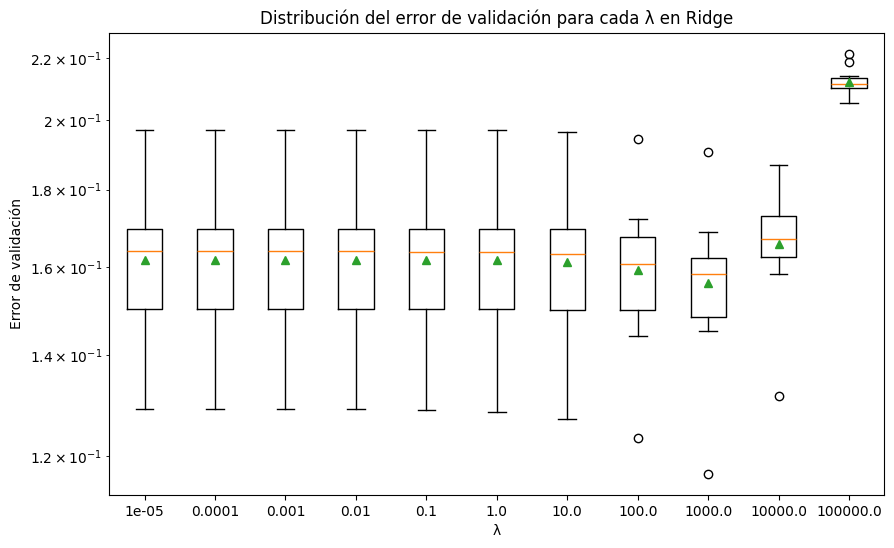

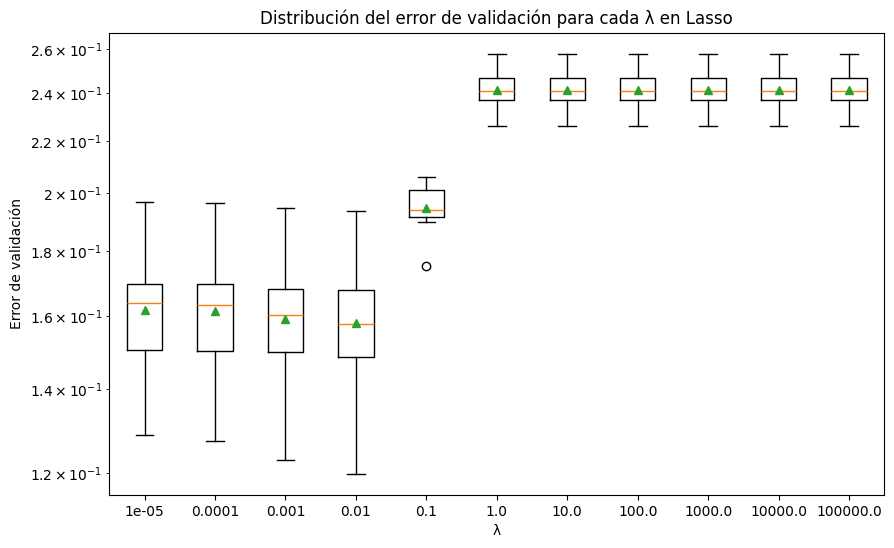

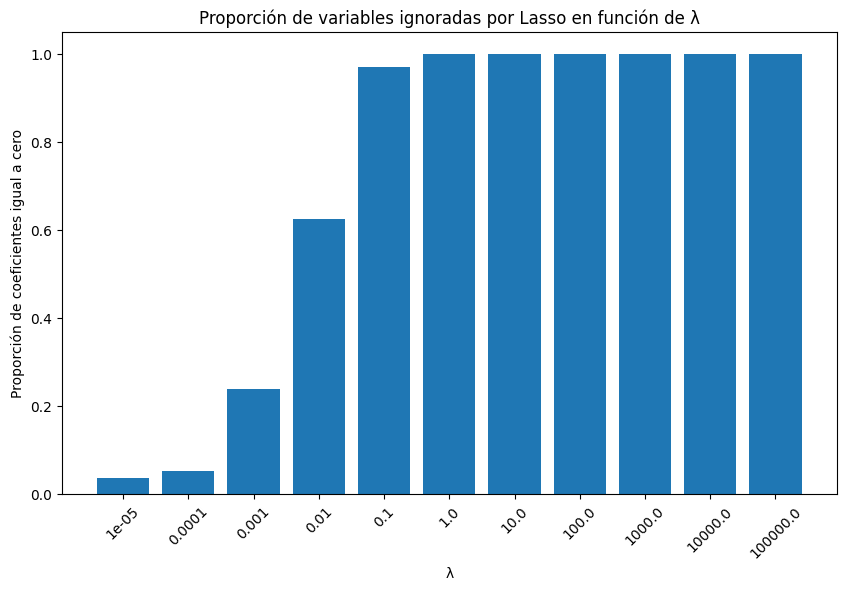

In [352]:
# tarda 1 minuto y medio en correr

# Datos iniciales y modelos
lambdas = np.logspace(-5, 5, 11)

# Configuración para los box-plots
errores_ridge = []
errores_lasso = []
proporcion_ceros_lasso = []

for lam in lambdas:
    # Ridge
    ridge = Ridge(alpha=lam)
    mse_ridge = -cross_val_score(ridge, X_transformado, y, cv=10, scoring='neg_mean_squared_error')
    errores_ridge.append(mse_ridge)
    
    # Lasso
    lasso = Lasso(alpha=lam, max_iter=5000)
    mse_lasso = -cross_val_score(lasso, X_transformado, y, cv=10, scoring='neg_mean_squared_error')
    errores_lasso.append(mse_lasso)
    
    lasso.fit(X_transformado, y)
    proporcion_ceros = np.mean(lasso.coef_ == 0)
    proporcion_ceros_lasso.append(proporcion_ceros)

# Ridge
plt.figure(figsize=(10, 6))
plt.boxplot(errores_ridge, labels=np.round(lambdas, 5), showmeans=True)
plt.title("Distribución del error de validación para cada λ en Ridge")
plt.xlabel("λ")
plt.ylabel("Error de validación")
plt.yscale("log")
plt.show()

# Lasso
plt.figure(figsize=(10, 6))
plt.boxplot(errores_lasso, labels=np.round(lambdas, 5), showmeans=True)
plt.title("Distribución del error de validación para cada λ en Lasso")
plt.xlabel("λ")
plt.ylabel("Error de validación")
plt.yscale("log")
plt.show()

# Eliminadas
plt.figure(figsize=(10, 6))
plt.bar(range(len(lambdas)), proporcion_ceros_lasso, tick_label=np.round(lambdas, 5))
plt.title("Proporción de variables ignoradas por Lasso en función de λ")
plt.xlabel("λ")
plt.ylabel("Proporción de coeficientes igual a cero")
plt.xticks(rotation=45) 
plt.show()

## EJERCICIO 7

In [353]:
print("Error cuadrático medio con Ridge: ", mean_squared_error(y_test, ridge_pred))
print("Error cuadrático medio con Lasso: ", mean_squared_error(y_test, lasso_pred))

# El mejor modelo es Ridge pero los resultados son bastante similares

Error cuadrático medio con Ridge:  0.14478888792553532
Error cuadrático medio con Lasso:  0.14409204366785008


## EJERCICIO 9

In [354]:
print("recordamos que tienen tamaños distintos:", "\n",
      "respondieron", respondieron.shape, "\n",
      "norespondieron", norespondieron.shape
      )

norespondieron['Unos'] = 1 # columna de unos para el intercepto como en respondieron
X_norespondieron = norespondieron[[i for i in X.columns]]

X_norespondieron = X_norespondieron.fillna(0)

scaler = StandardScaler()
X_norespondieron_scaled = scaler.fit_transform(X_norespondieron)


model = LogisticRegression(penalty='l1', C=0.001, solver='liblinear', random_state=42) 
model.fit(X_transformado_train, y_train) 

pred_norespondieron = model.predict(X_norespondieron_scaled)


print('proporción de pobres en no respondieron:', sum(pred_norespondieron)/len(pred_norespondieron))

# el numero de pobres es 51.8%, bastante cercana a la que habiamos obtenido antes con la base de respuesta


recordamos que tienen tamaños distintos: 
 respondieron (4422, 169) 
 norespondieron (2953, 168)
proporción de pobres en no respondieron: 0.5110057568574331


/Users/federicolopez/Library/CloudStorage/OneDrive-Personal/Documents/UDESA/07/BIG-DATA/TUTORIALES/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
